In [1]:
!nvidia-smi

Sat Jul 18 07:47:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!fuser -k /dev/nvidia*

In [2]:
!nvidia-smi

Sat Jul 18 08:03:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

nvidia-persistenced failed to initialize. Check syslog for more details.
Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [2]:
import sys
sys.path.append("..")
# print(sys.path)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from core import *
from torch_backend import *

colors = ColorMap()
draw = lambda graph: display(DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}))

In [30]:
help(nesterov_update)

TypeError: nesterov_update() missing 8 required positional arguments: 'weight_id', 'w', 'dw', 'v', 'lr', 'weight_decay', 'momentum', and 'lr_instead'

### Network definitions

In [23]:
batch_norm = partial(BatchNorm, weight_init=None, bias_init=None)

In [39]:
help(batch_norm.func)

Help on class BatchNorm in module torch_backend:

class BatchNorm(torch.nn.modules.batchnorm.BatchNorm2d)
 |  Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs
 |  with additional channel dimension) as described in the paper
 |  `Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift`_ .
 |  
 |  .. math::
 |  
 |      y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
 |  
 |  The mean and standard-deviation are calculated per-dimension over
 |  the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
 |  of size `C` (where `C` is the input size). By default, the elements of :math:`\gamma` are set
 |  to 1 and the elements of :math:`\beta` are set to 0.
 |  
 |  Also by default, during training this layer keeps running estimates of its
 |  computed mean and variance, which are then used for normalization during
 |  evaluation. The running estimates are kept with a def

In [24]:
def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), ['relu1'])
    block['add'] =  (Add(), [('conv3' if projection else 'relu1'), 'branch/conv2'])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), ['in']),
        'concat': (Concat(), ['maxpool', 'avgpool']),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'input': (None, []),
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'logits': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        # 'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'bn': batch_norm(c_out, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep'], bn_weight_init=1.0, **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), ['in', 'res2/relu'])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

### Download and preprocess data

In [25]:
DATA_DIR = './data'
dataset = cifar10(DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

Preprocessing training data
Finished in 1.9 seconds
Preprocessing test data
Finished in 0.088 seconds


### Training loop

In [26]:
def train(model, lr_schedule, train_set, test_set, batch_size, num_workers=0):
    train_batches = DataLoader(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = DataLoader(test_set, batch_size, shuffle=False, num_workers=num_workers)
    
    lr = lambda step: lr_schedule(step/len(train_batches))/batch_size
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(lr_schedule.knots[-1]):
        logs.append(union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, 
                          train_epoch(state, Timer(torch.cuda.synchronize), train_batches, test_batches)))
    return logs

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

普通的残差块包含了一个identity shortcut并保留了输入的空间和通道维度：

block0的下采样模块将空间分辨率降低两倍，输出通道的数量增加一倍：

加入残差模块的原因是通过在网络中创建shortcut让优化变得更简单。我们希望较短的路径代表相对容易训练的浅层子网络，而较长的路径可以增加网络的能力和计算深度。这样一来，研究最短路径如何通过网络孤立训练，并且如何采取措施进行改进似乎是合理的。


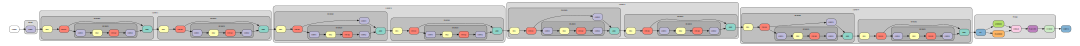

TypeError: nesterov_update() missing 1 required positional argument: 'lr_instead'

In [27]:
# 0.9441 -> 7*35=245s
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=1)

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - 0 dataloader processes (297s)

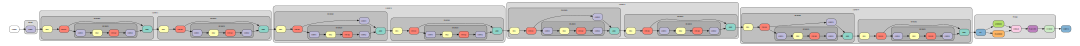

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.0067       6.4698       1.6608       0.3892       0.4087       1.9859       0.4338       6.8785
           2       0.0133       6.4005       1.0271       0.6326       0.4105       0.9852       0.6580       6.8111
           3       0.0200       6.4838       0.7693       0.7315       0.4090       0.7403       0.7516       6.8928
           4       0.0267       6.3937       0.6452       0.7770       0.4102       0.7837       0.7491       6.8038
           5       0.0333       6.9812       0.5751       0.8026       0.4114       0.6352       0.7848       7.3926
           6       0.0400       7.1256       0.5124       0.8241       0.4083       0.5472       0.8146       7.5339
           7       0.0467       7.5370       0.4751       0.8398       0.4113       0.4627       0.8406       7.9483
           8       0.0533       6.8809       0.4355       0.8502

In [10]:
# 0.9401 -> 35 *7
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 2: Mini-batches](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_2/) - batch size=512 (256s)

In [9]:
# 0.9409 512 35*5=175
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0293       6.5629       1.7671       0.3513       0.4458       1.3767       0.5178       6.5629
           2       0.0587       4.9274       1.0808       0.6107       0.3212       1.7736       0.5080       4.9274
           3       0.0880       4.9191       0.8158       0.7141       0.2861       0.9341       0.7011       4.9191
           4       0.1173       4.9248       0.6552       0.7722       0.2869       0.7603       0.7524       4.9248
           5       0.1467       4.9313       0.5688       0.8060       0.2859       0.6299       0.7916       4.9313
           6       0.1760       4.9227       0.4831       0.8345       0.3112       0.5330       0.8171       4.9227
           7       0.2053       4.9299       0.4414       0.8470       0.2863       0.8855       0.7289       4.9299
           8       0.2347       4.9256       0.4024       0.8610

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - speed up batch norms (186s)

In [10]:
# .half 半精度 512 35*4.4=154
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0293       4.3623       1.7399       0.3580       0.2939       1.2748       0.5400       4.3623
           2       0.0587       4.3687       1.1173       0.5987       0.2936       1.1750       0.6078       4.3687
           3       0.0880       4.3675       0.8360       0.7090       0.2938       0.8180       0.7337       4.3675
           4       0.1173       4.3668       0.6598       0.7732       0.2915       0.6189       0.7910       4.3668
           5       0.1467       4.3773       0.5514       0.8107       0.2917       0.6309       0.7868       4.3773
           6       0.1760       4.3618       0.4897       0.8320       0.2909       0.6280       0.7949       4.3618
           7       0.2053       4.3603       0.4404       0.8483       0.2938       0.6320       0.7832       4.3603
           8       0.2347       4.3614       0.4105       0.8555

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - cutout+30 epochs+batch_size=512 (161s)

In [11]:
# 4.36*30=130.8
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.4, 0])
batch_size = 512

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0500       4.3654       1.7410       0.3651       0.2913       1.3271       0.5247       4.3654
           2       0.1000       4.3668       1.1924       0.5752       0.2911       1.0384       0.6457       4.3668
           3       0.1500       4.3884       0.9033       0.6834       0.2911       0.8674       0.6991       4.3884
           4       0.2000       4.3668       0.7290       0.7453       0.2911       0.7244       0.7509       4.3668
           5       0.2500       4.3661       0.6317       0.7803       0.2913       0.6201       0.7866       4.3661
           6       0.3000       4.3663       0.5699       0.8020       0.2911       0.6264       0.7896       4.3663
           7       0.3500       4.4013       0.5278       0.8189       0.2912       0.6651       0.7794       4.4013
           8       0.4000       4.3663       0.5022       0.8269

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/)  - batch_size=768 (154s)

In [12]:
# 768 4.27*30=128.1
# 跳到最后
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.6, 0])
batch_size = 768

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0750       5.6769       1.8617       0.3316       0.2920       2.1002       0.3935       5.6769
           2       0.1500       4.2685       1.3081       0.5284       0.2912       1.5002       0.5069       4.2685
           3       0.2250       4.2715       0.9973       0.6514       0.3227       4.6497       0.3220       4.2715
           4       0.3000       4.2705       0.7941       0.7245       0.2921       0.8089       0.7274       4.2705
           5       0.3750       4.2728       0.6764       0.7659       0.2918       0.9898       0.6692       4.2728
           6       0.4500       4.2839       0.5953       0.7930       0.2956       1.1169       0.6429       4.2839
           7       0.5250       4.2710       0.5424       0.8120       0.2940       0.7683       0.7378       4.2710
           8       0.6000       4.2888       0.5202       0.8196

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone (36s; test acc 55.9%)

It seems reasonable to study how the shortest path through the network trains in isolation and to take steps to improve this before adding back the longer branches. 
Eliminating the long branches yields the following backbone network in which all convolutions, except for the initial one, have a stride of two.

Training the shortest path network for 20 epochs yields an unimpressive test accuracy of 55.9% in 36 seconds.

加入残差模块的原因是通过在网络中创建shortcut让优化变得更简单。我们希望较短的路径代表相对容易训练的浅层子网络，而较长的路径可以增加网络的能力和计算深度。这样一来，研究最短路径如何通过网络孤立训练，并且如何采取措施进行改进似乎是合理的。

清除长分支(2个conv) 会生成一下主要网络，其中除了第一个网络，所有的卷积网络的步长都为2：

在接下来的实验中，我们会训练20个epoch，利用比之前学习速率更快速的版本训练，因为网络较小，收敛得更快。

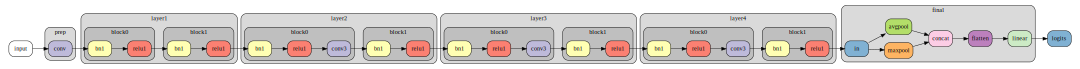

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       2.2117       2.1469       0.2458       0.1176       1.9036       0.2977       2.3293
           2       0.2000       1.9308       1.7874       0.3439       0.1187       1.6594       0.3901       2.0495
           3       0.3000       2.2888       1.7013       0.3797       0.1524       1.5892       0.4263       2.4412
           4       0.4000       1.8357       1.6715       0.3929       0.1182       1.6260       0.4075       1.9539
           5       0.3750       1.6965       1.6401       0.4044       0.1173       1.5476       0.4401       1.8139
           6       0.3500       1.7076       1.5975       0.4242       0.1173       1.6094       0.4124       1.8248
           7       0.3250       1.8048       1.5813       0.4296       0.1170       1.5078       0.4573       1.9218
           8       0.3000       1.6899       1.5536       0.4392

In [14]:
def shortcut_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), ['relu1'])
    return block

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, remove repeat bn-relu (32s; test acc 56.0%)

Removing the repeated batch norm-ReLU groups, reduces training time to 32s and leaves test accuracy approximately unchanged.

对最短的路径网络训练20个epoch，在36秒内的测试精度仅达到55.9%。删除掉重复的批标准化ReLU群组，将训练时间缩短到32秒，但是测试精度仍然不变。

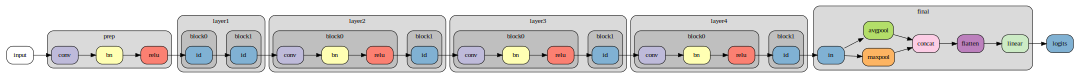

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       2.1321       2.1419       0.2574       0.1403       1.7415       0.3699       2.2723
           2       0.2000       1.5673       1.7831       0.3461       0.1109       1.6860       0.3813       1.6781
           3       0.3000       1.5846       1.7004       0.3819       0.1116       1.6471       0.4108       1.6962
           4       0.4000       1.9542       1.6763       0.3914       0.1135       1.6150       0.4159       2.0677
           5       0.3750       1.9119       1.6391       0.4080       0.1108       1.5831       0.4360       2.0226
           6       0.3500       1.5724       1.6019       0.4234       0.1112       1.5303       0.4419       1.6836
           7       0.3250       1.5665       1.5721       0.4315       0.1120       1.4848       0.4677       1.6784
           8       0.3000       1.5766       1.5540       0.4423

In [13]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv':  nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 3x3 convs (36s; test acc 85.6%)

A serious shortcoming of this network is that the downsampling convolutions have 1x1 kernels and a stride of two, so that rather than enlarging the receptive field they are simply discarding information. 

If we replace these with 3x3 convolutions, things improve considerably and test accuracy after 20 epochs is 85.6% in a time of 36s.

这一网络有个严重的缺陷，即下采样卷积有1×1的核以及为2的步长，所以与其扩大接受域，它们反而会抛弃信息。如果我们用3×3的卷积替换，测试精度在36秒的训练后达到了85.6%。

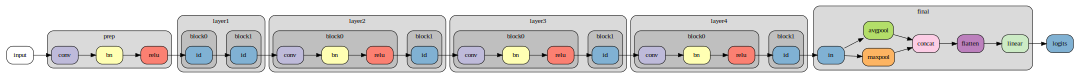

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       2.4609       1.9192       0.3355       0.1682       1.5141       0.4556       2.6291
           2       0.2000       1.6018       1.4553       0.4765       0.1107       1.2637       0.5463       1.7126
           3       0.3000       1.6175       1.2104       0.5676       0.1114       1.0380       0.6346       1.7289
           4       0.4000       1.6318       1.1108       0.6050       0.1108       1.1542       0.6068       1.7426
           5       0.3750       1.6045       0.9961       0.6462       0.1109       0.9412       0.6698       1.7153
           6       0.3500       1.6191       0.9086       0.6806       0.1390       0.8327       0.7107       1.7581
           7       0.3250       1.6015       0.8341       0.7071       0.1113       0.7559       0.7362       1.7128
           8       0.3000       1.5987       0.7869       0.7225

In [15]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, maxpool downsampling (43s; test acc 89.7%)

We can further improve the downsampling stages by applying 3x3 convolutions of stride one followed by a pooling layer instead of using strided convolutions. 

We choose max pooling with a 2x2 window size leading to a final test accuracy of 89.7% after 43s. Using average pooling gives a similar result but takes slightly longer.

我们还能继续对下采样进行优化，使用3×3、步长为1的卷积，并且后面跟一个池化层。我们选择最大池化和2×2的窗口大小，43秒训练后的测试精度为89.7%。用平均池化法得到相似的结果，但时间稍长。

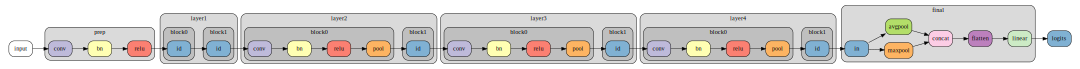

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       3.2221       2.0100       0.3300       0.2553       1.3769       0.5006       3.4774
           2       0.2000       2.0515       1.3419       0.5208       0.1278       1.2265       0.5676       2.1793
           3       0.3000       2.0101       1.0755       0.6214       0.1272       1.1556       0.6030       2.1373
           4       0.4000       2.0084       0.9613       0.6675       0.1272       0.8198       0.7109       2.1356
           5       0.3750       2.0086       0.8121       0.7176       0.1271       0.9382       0.7068       2.1357
           6       0.3500       2.0329       0.7240       0.7488       0.1275       0.7074       0.7617       2.1604
           7       0.3250       2.0019       0.6584       0.7740       0.1272       0.6793       0.7667       2.1291
           8       0.3000       2.0076       0.6158       0.7855

In [16]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 2x output dim, global maxpool (47s; test acc 90.7%)

The final pooling layer before the classifier is a concatenation of global average pooling and max pooling layers, inherited from the original network. 

We replace this with a more standard global max pooling layer and double the output dimension of the final convolution to compensate for the reduction in input dimension to the classifier, leading to a final test accuracy of 90.7% in 47s. Note that average pooling at this stage underperforms max pooling significantly.

分类器前的最后一个池化层是全局平均池化层和最大池化层的连接，从原始网络中得来。我们用更标准的全局最大池化层替换它，并且将最终的卷积层的输出维度变为原来的两倍，对输入维度进行补偿，最终在47秒内，测试精度达到了90.7%。注意，这一阶段的平均池化层并不如最大池化层。


In [17]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

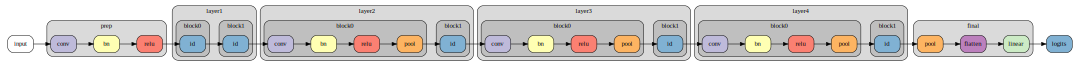

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       2.7031       2.4758       0.2650       0.1880       1.8639       0.3563       2.8911
           2       0.2000       2.2133       1.5209       0.4504       0.1408       1.2320       0.5561       2.3541
           3       0.3000       2.2021       1.1923       0.5765       0.1409       0.9681       0.6638       2.3429
           4       0.4000       2.2101       1.0336       0.6385       0.1407       0.9269       0.6630       2.3508
           5       0.3750       2.2309       0.8647       0.7009       0.1733       0.6732       0.7651       2.4041
           6       0.3500       2.2465       0.7384       0.7443       0.1410       0.9415       0.6991       2.3875
           7       0.3250       2.2017       0.6586       0.7719       0.1406       0.6550       0.7725       2.3424
           8       0.3000       2.2047       0.6240       0.7836

In [18]:
# 2.2 * 20 =44
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(c=[64,128,256,512], block=shortcut_block, prep_bn_relu=True, concat_pool=False)
draw(build_graph(n))

# n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
# draw(build_graph(n))

model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, bn scale init=1, classifier weight=0.125 (47s; test acc 91.1%)

By default in PyTorch (0.4), initial batch norm scales are chosen uniformly at random from the interval [0,1]. Channels which are initialised near zero could be wasted so we replace this with a constant initialisation at 1. 
This leads to a larger signal through the network and to compensate we introduce an overall constant multiplicative rescaling of the final classifier. A rough manual optimisation of this extra hyperparameter suggest that 0.125 is a reasonable value. 
(The low value makes predictions less certain and appears to ease optimisation.) 

With these changes in place, 20 epoch training reaches a test accuracy of 91.1% in 47s. 

默认情况下，在PyTorch0.4中，初始批规范化的范围在0到1之间随机选择。初始接近0的通道可能被浪费，所以我们用常数1来替代。这导致通过网络中的信号更大。为了补偿，我们提出了一种整体恒定惩罚对分类器进行重新调整。对这一额外超参数，大致的手动优化值是0.125。经过这些改变，经过20个epoch的训练，网络在47秒内达到了91.1%的测试精度。

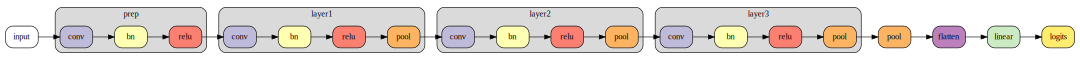

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       2.2730       1.8263       0.3552       0.1410       1.4214       0.4798       2.4140
           2       0.2000       2.2184       1.1380       0.6014       0.1408       0.9644       0.6553       2.3592
           3       0.3000       2.2343       0.8711       0.6994       0.1436       0.8634       0.6971       2.3778
           4       0.4000       2.2088       0.7577       0.7413       0.1422       0.6775       0.7683       2.3510
           5       0.3750       2.2395       0.6575       0.7769       0.1407       0.7841       0.7394       2.3802
           6       0.3500       2.2085       0.5796       0.8057       0.1407       0.6780       0.7659       2.3492
           7       0.3250       2.2816       0.5424       0.8187       0.1644       0.6664       0.7724       2.4460
           8       0.3000       2.2771       0.5044       0.8319

In [19]:
# classifier weight=0.125
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net(extra_layers=(), res_layers=())
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

现在的网络看起来没什么问题了，接下来我们要进行收益递减，添加一些图层。目前网络仅有5个图层（四个卷积，一个全连接层），所以还不确定我们是否需要残差分支，或者添加额外的层后能否得到94%的目标精确度。

如果只增加宽度似乎不可行。如果我们让通道维度增加一倍，训练60个epoch后，可以达到93.5%的精确度，但是会用321秒。

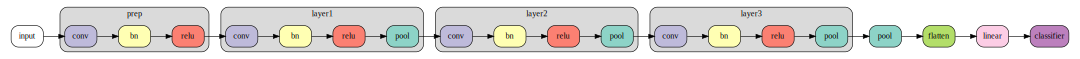

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       9.6687       1.8879       0.3291       0.7929       1.6214       0.4464      10.4616
           2       0.0667       5.3167       1.2460       0.5628       0.3784       1.0503       0.6263      16.1567
           3       0.1000       5.3180       0.9350       0.6807       0.3807       0.7622       0.7368      21.8554
           4       0.1333       5.3191       0.7673       0.7385       0.3788       0.7431       0.7427      27.5533
           5       0.1667       5.3328       0.6730       0.7719       0.3793       0.7541       0.7432      33.2654
           6       0.2000       5.3204       0.6109       0.7939       0.3790       0.5805       0.8037      38.9648
           7       0.2333       5.3206       0.5681       0.8102       0.3781       0.5228       0.8300      44.6635
           8       0.2667       5.3186       0.5294       0.8226

In [10]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
c = 128

n = net(channels={'prep': c, 'layer1': 2*c, 'layer2': 4*c, 'layer3': 8*c}, extra_layers=(), res_layers=())
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 


在增加网络深度方面，我们还面临着多种问题，例如不同的残差分支类型、深度和宽度以及新的超参数，例如初始范围和残差分支的偏见。为了让结果更进一步，我们要严格限制搜索空间，所以，不能调整任何新的超参数。

特别的是，我们要考虑两种类型的网络。第一种是选择性地在每个最大池化层后添加一个卷积层。第二种是添加一个含有两部分3×3卷积的残差块，其中有identity shortcut，也是在最大池化层之后添加。

我们在最后卷积模块后、全局最大池化层之前插入了一个2×2的最大池化层。是否添加新层要根据不同情况决定，我们还考虑混合两种类型，但这并没有提升性能，所以我们就不在此展开了。

下图是第一种网络示例，其中我们在第二个最大池化层之后添加了额外的卷积：

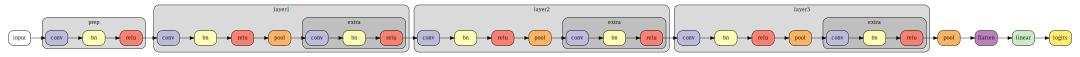

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.0333       3.6367       1.8801       0.3379       0.2691       1.3061       0.5160       3.9058
           2       0.0667       2.8594       1.1722       0.5827       0.1908       0.9385       0.6631       3.0502
           3       0.1000       2.8524       0.8909       0.6853       0.1932       0.8700       0.7002       3.0456
           4       0.1333       2.8480       0.7637       0.7339       0.1907       0.8236       0.7210       3.0387
           5       0.1667       2.8484       0.6838       0.7637       0.2153       0.8127       0.7312       3.0637
           6       0.2000       2.8505       0.6300       0.7837       0.1906       0.6778       0.7693       3.0411
           7       0.2333       2.8475       0.5829       0.7997       0.1905       0.5473       0.8143       3.0381
           8       0.2667       2.8517       0.5577       0.8083

In [20]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
cutout=12

n = net(extra_layers=['layer1', 'layer2', 'layer3'], res_layers=())
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network Residual:L1+L3, 20 epochs (66s; test acc 93.7%)

下图是第二种网络示例，其中我们在第一和第三层之后添加了残差分支：

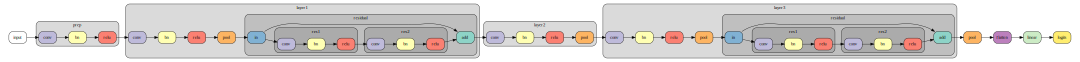

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.1000       3.1863       1.6096       0.4193       0.2147       1.3677       0.5235       3.4009
           2       0.2000       3.1518       0.9238       0.6710       0.2144       0.9652       0.6774       3.3662
           3       0.3000       3.1508       0.7236       0.7488       0.2144       0.9161       0.6938       3.3652
           4       0.4000       3.1461       0.6277       0.7827       0.2142       0.7181       0.7562       3.3603
           5       0.3750       3.1748       0.5427       0.8118       0.2163       0.5971       0.7953       3.3912
           6       0.3500       3.1490       0.4714       0.8380       0.2145       0.5292       0.8160       3.3635
           7       0.3250       3.1505       0.4203       0.8547       0.2163       0.4836       0.8372       3.3668
           8       0.3000       3.1487       0.3941       0.8651

In [21]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network, 24 epochs (79s; test acc 94.1%)


现在要开始“暴力”架构搜索了！我们训练了15种网络（经过改进的原始网络和上述两类网络中每类的7种变体），各训练20个epoch，另外还对比了训练22个epoch的结果，了解训练时间增长和更深的网络架构之间的差别。如果每个实验仅运行一次，就会花费30分钟的计算时间。但不幸的是，每次最终测试精度的标准偏差约为0.15%。所以为了得出准确的结果，我们会对每个实验运行10次，将每个数据点的标准偏差控制在0.05%左右。即便如此，不同架构之间从20到22个epoch运行后改进率之间的差异主要可能是噪音。

以下是结果，点表示20个epoch和精确度，线条的延伸表示22个epoch的结果：

与运用更深层的架构所得到的进步相比，训练更长时间所得到的进步速度似乎很慢。在测试的框架中，最有前景的或许是Residual:L1+L3。网络在66秒内达到了93.8%的精确度，如果我们将训练扩展到24个epoch，平均精确度为94.08%，训练时间为79秒。

目前为止，我们已经得到了一个9层的深度残差网络，能在79秒内达到94%的训练精确度，几乎将训练时间缩短了一半。最后还有一个问题：我们是否真的需要残差分支才能让测试精确度达到94%？答案显然是否定的。例如，单一的分支网络Extra:L1+L2+L3能在180秒、60个epoch内达到95%的精确度，加上正则化或更宽的版本后，精确度会更高。但是至少在现在最快的是一个残差网络。

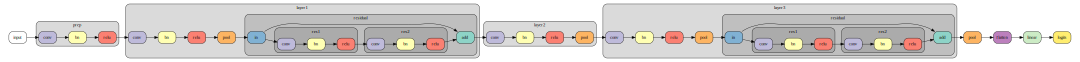

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       0.0800       3.1988       1.6390       0.4100       0.2172       1.2901       0.5335       3.4160
           2       0.1600       3.1673       0.9502       0.6635       0.2173       1.2551       0.5954       3.3846
           3       0.2400       3.2040       0.7292       0.7433       0.2585       0.8271       0.7203       3.4625
           4       0.3200       3.6405       0.6332       0.7804       0.2314       0.7558       0.7436       3.8719
           5       0.4000       3.5192       0.5576       0.8065       0.2142       0.7025       0.7568       3.7334
           6       0.3789       3.1533       0.4988       0.8289       0.2142       0.7907       0.7341       3.3675
           7       0.3579       3.1479       0.4429       0.8480       0.2141       0.6516       0.7803       3.3620
           8       0.3368       3.1667       0.4106       0.8594

In [22]:
# 改完结构之后 3.15*24=75.6
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512

n = net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

本文结束前，让我们再简单回顾一下研究的目的。很多观点认为，训练模型在CIAFR10上达到94%的测试精确度是无意义的行为，应为现在最高的精确度都达到98%了（另外还有人认为现在ImageNet才是“唯一”的数据集，其他实验只是浪费时间罢了）。

事实上，我们可以通过9层网络在24个epoch内达到94%的精确度，这也再次说明我们的目标门槛过低。另一方面，人类在CIFAR10上的表现也在94%左右，所以这一情况并不清楚。

在某种程度上，现在的精确度是一种“病态”的目标，只追求更大的模型、调整更多超参数、更多数据增强或者更长的训练时间，让各种工作之间的比较更难。另外，在训练或结构设计上的创新会带来额外的超参数维度，并且调整这些参数可能会导致有关训练更好的隐式优化，否则这些与研究中的扩展无关。如果基础模型的外显超参数的维度空间较低，那么通常被认为是最佳的对比试验无法解决该问题。这种情况的结果是，最先进的模型难以进行比较、复现、重建。

有了这些问题，我们认为任何能轻易在各项实验中进行比较的都是有益的。我们相信创建有竞争力的基准也是应对挑战的一种方法。资源的限制让各实验之间的比较更公平，减少了为了培训所需要做的调整。模型多余的复杂性可能会受到资源限制基线的惩罚，哪些明确控制相关参数的方法通常会获胜。

最近，根据模型推理时间或模型大小公布曲线越来越多。这对于优化和解决上面的问题来说都是积极的方法，但我们相信训练时间所带来的额外正则化会有更多好处。另一方面，优化训练时间并不考虑推理成本是否是次优的，这也是为什么我们的训练时间结构总是包含测量每个epoch中测试集的时间，并且我们避免了类似测试时间增强等技术，它可以在推理时减少训练时间。

## 构建帕累托曲线， 搜索最优模型